In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
from util import RuleClassifier, get_complexity, evaluate_counterfactual_fidelity
from comparers import ModelComparer
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances,\
                       estimate_feature_interaction_order, print_rules
from clustering import make_clustering, plot_joint_feature_dependence
import matplotlib.pyplot as plt
from IPython.display import display
import shap
import warnings
shap.initjs()
warnings.filterwarnings(action='ignore', category=UserWarning)  # xgboost classifiers print lots of warnings

# Setup Task

In [2]:
with open('task_without_noise.pickle', 'rb') as f:
    clf_a, clf_b, X, X_display, y, feature_names, categorical_features, feature_precisions = pickle.load(f)

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [4]:
# Do not sample from background data set, use all
masker = shap.maskers.Independent(data=X, max_samples=len(X))

In [6]:
%%time
indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker, algorithm='exact',
                                               explanation_type='indiv', space_type='log_odds')
with open('indiv.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)

Exact explainer: 978it [33:03,  2.04s/it]                         

CPU times: user 1h 45min 23s, sys: 5min 58s, total: 1h 51min 22s
Wall time: 33min 3s


In [7]:
%%time
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, algorithm='exact', explanation_type='mclass_diff', space_type='log_odds')
with open('diffclf.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

Exact explainer: 978it [36:29,  2.25s/it]                         

CPU times: user 1h 44min 48s, sys: 6min 3s, total: 1h 50min 52s
Wall time: 36min 29s


# Traditional SHAP Explanations

In [179]:
with open('indiv.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

In [180]:
# For binary classification problems only the positive class is interesting
indiv_shap_values = indiv_shap_values[:, :, ['A.True', 'B.True']]

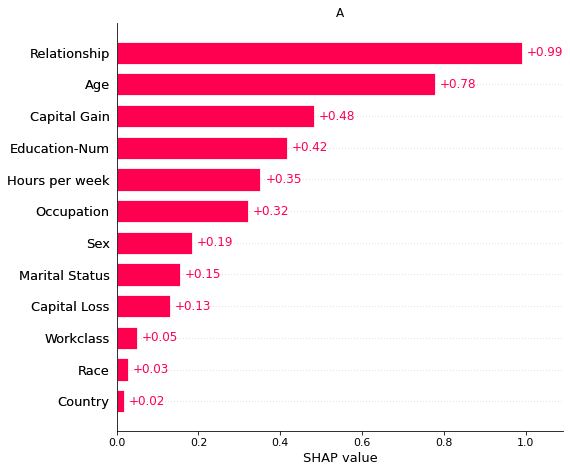

In [181]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'A.True'])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

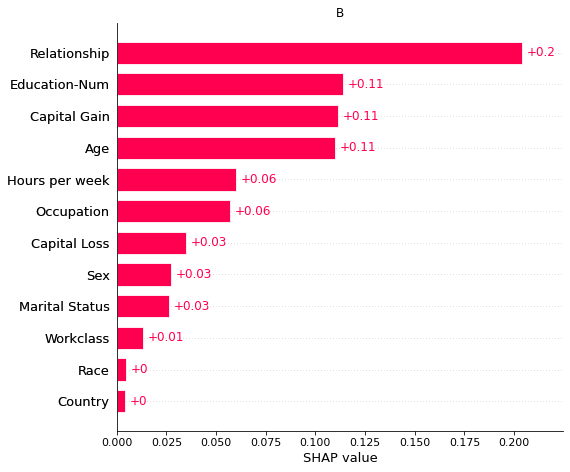

In [182]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'B.True'])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [183]:
%%time
node = make_clustering(comparer, indiv_shap_values)

CPU times: user 4.74 s, sys: 1.31 s, total: 6.06 s
Wall time: 7.48 s


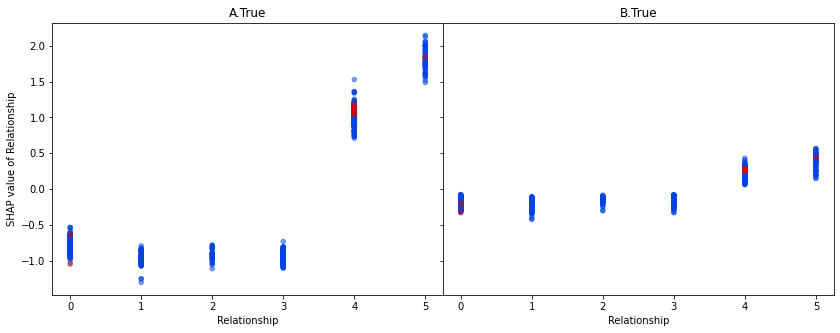

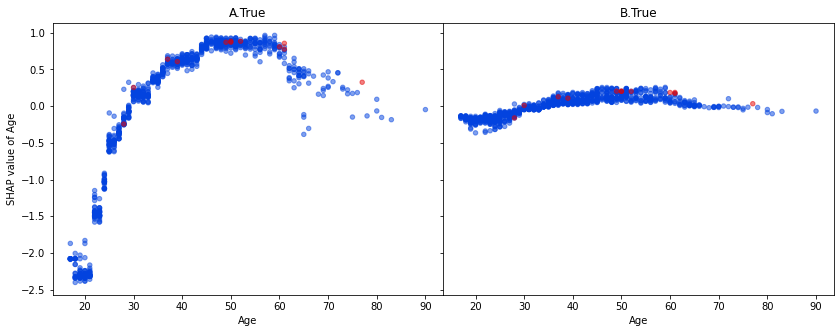

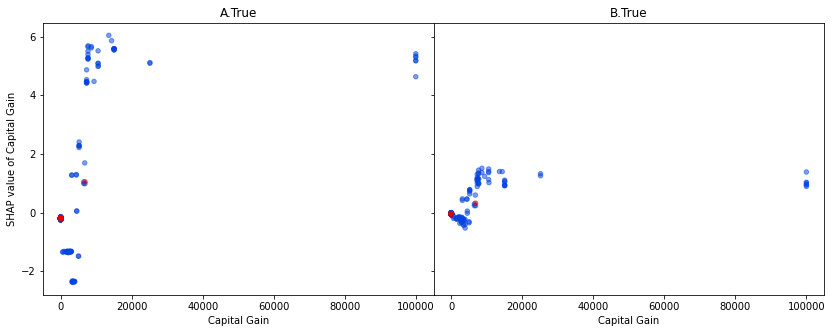

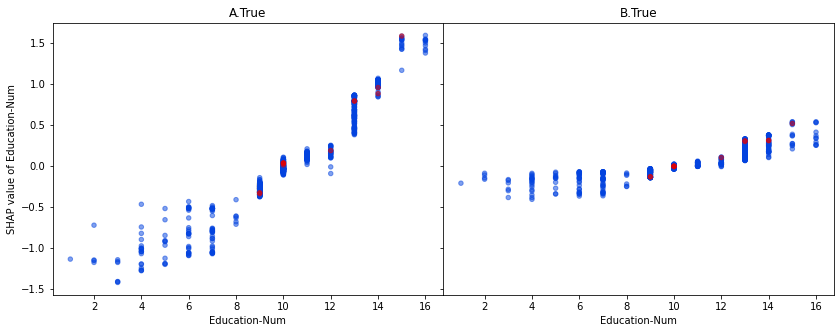

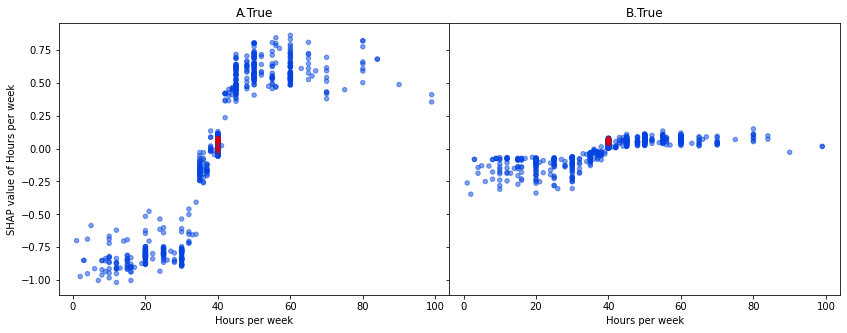

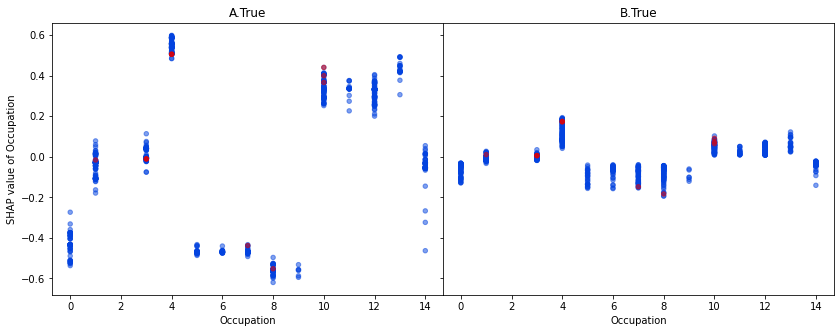

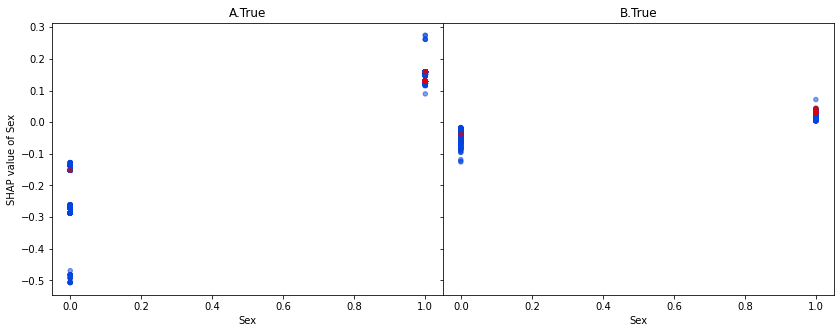

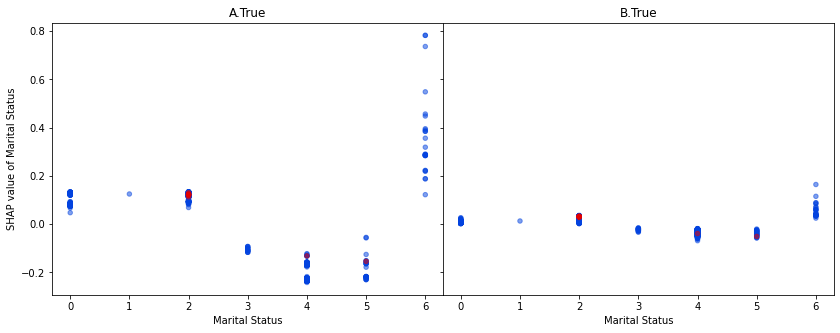

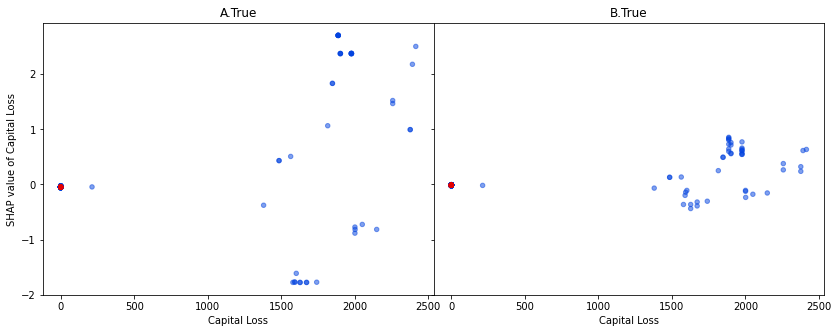

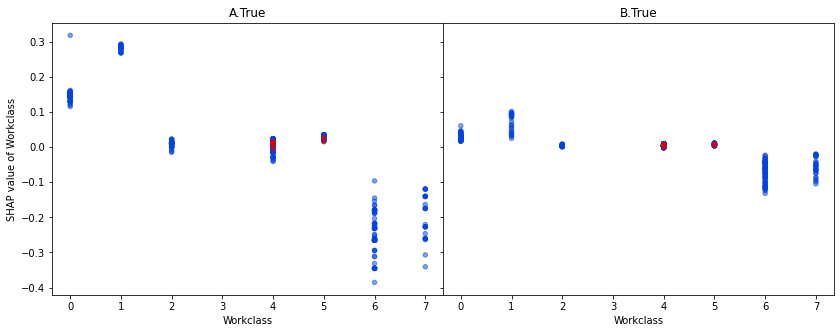

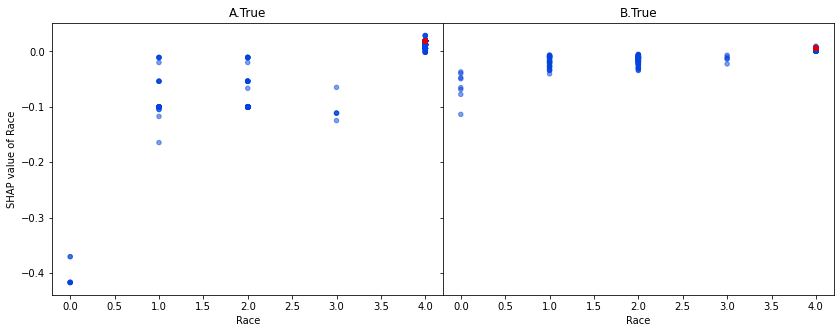

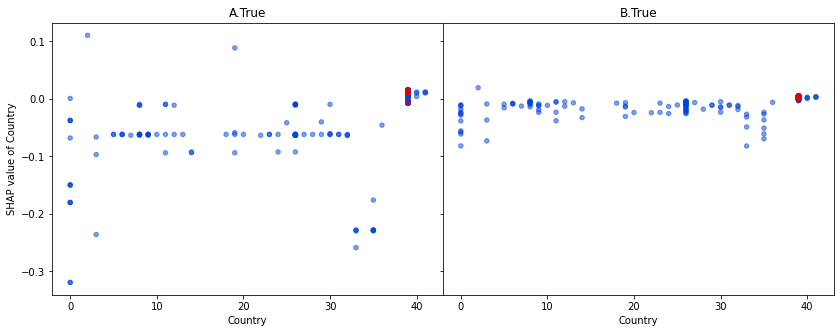

In [184]:
for feature in node.features_ordered:
    node.plot_feature_dependence(feature, alpha=0.5)

# Difference Classifier SHAP Explanations

In [4]:
with open('diffclf.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

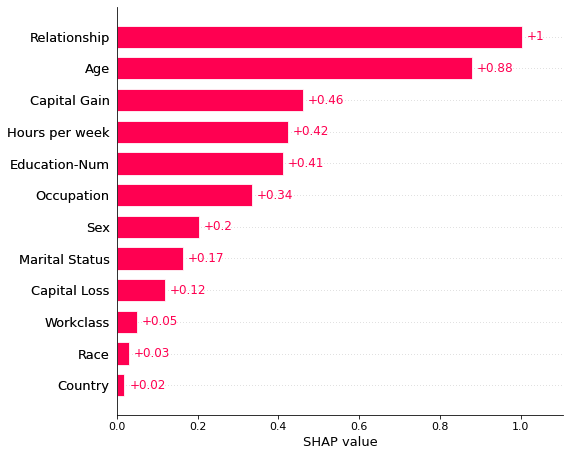

In [5]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

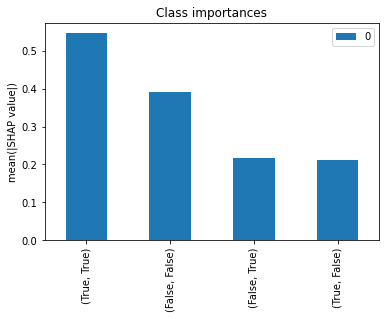

In [6]:
class_order, class_importances = calc_class_order(diffclf_shap_values)
plot_class_importances(class_importances, class_order, diffclf_shap_values.output_names)

In [7]:
def plot(feature):
    node.describe_feature_differences(feature)
    pprint(node.counterfactuals[feature])
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

In [26]:
def plot_2d(node, x, y):
    comparer.plot_decision_boundaries(node.root.data, type='bin-diffclf', x=x, y=y, alpha=0.5)
    for cf in node.counterfactuals[x]:
        plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
    for cf in node.counterfactuals[y]:
        plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

In [9]:
global_fidelities = {}
local_fidelities = {}
complexities = {}

## Clustering of Class $(False, True)$ SHAP Values

In [10]:
%%time
node = make_clustering(comparer, diffclf_shap_values, '(False, True)',
                       ['(False, False)', '(False, True)', '(True, True)'],
                       categorical_features=categorical_features,
                       feature_precisions=feature_precisions)
node.class_counts, node.distance

CPU times: user 7min 26s, sys: 31.7 s, total: 7min 57s
Wall time: 2min 37s


((False, False)    784
 (True, True)      181
 (False, True)      12
 dtype: int64,
 336.5608428431883)

In [11]:
with open(f'ground_truth.{node.focus_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

### Main Node (R)

In [132]:
node = node.root.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(R,
 (False, False)    784
 (True, True)      140
 (False, True)      12
 dtype: int64,
 145.6227662418017)

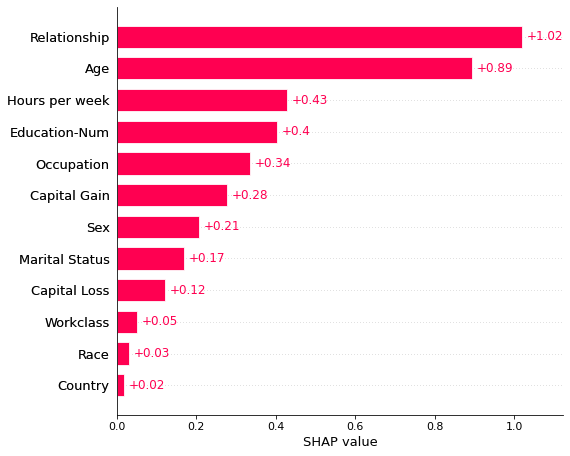

In [160]:
plot_feature_importance_bar(node.feature_importances)
plt.savefig('adult-featimp-main.pdf')

In [165]:
feature_it = iter(node.features_with_counterfactuals)
print(', '.join([f'\emph{{{feature}}}' for feature in node.features_with_counterfactuals]))

\emph{Age}, \emph{Hours per week}, \emph{Education-Num}, \emph{Capital Gain}, \emph{Marital Status}, \emph{Capital Loss}, \emph{Race}


difference class has a broad global high similar to class $(True, True)$. Lower values have increased probability to be classified $(False, False)$.

28.0 <= Age <= 77.0
[Lower CF: Age == 27.0 --> {'(False, False)': 12},
 Upper CF: Age == 80.0 --> {'(False, False)': 11, '(True, True)': 1}]


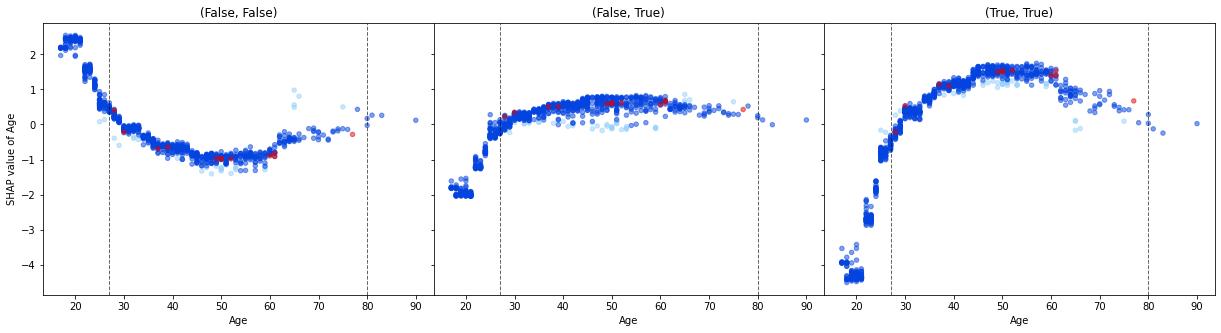

In [148]:
plot(next(feature_it))

difference class has a global high for high feature values, along with class $(True, True)$. All instances classified differently are $=40$ and would flip their prediction if they were 39 or 42.

Hours per week == 40.0
[Lower CF: Hours per week == 39.0 --> {'(False, False)': 12},
 Upper CF: Hours per week == 42.0 --> {'(True, True)': 12}]


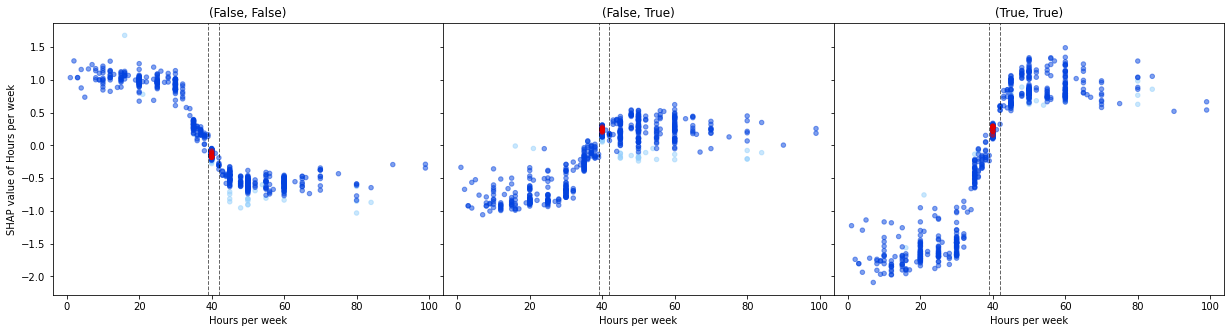

In [149]:
plot(next(feature_it))

difference class increase in outcome is steadily increasing, but with strong interaction effects present at high values. Instances classified differently have a wide range of higher values.

9.0 <= Education-Num <= 15.0
[Lower CF: Education-Num == 8.0 --> {'(False, False)': 12}]


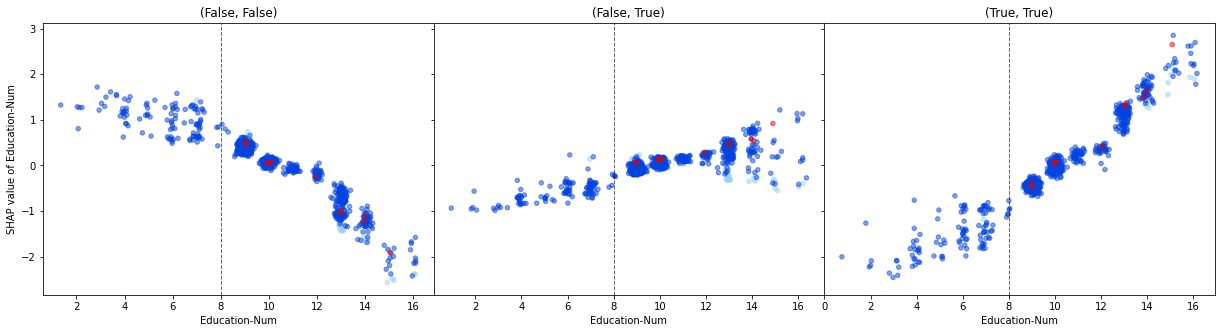

In [150]:
plot(next(feature_it))

above 7074, there is a high increase for class $(True, True)$, which makes them very unlikely for being classified differently.

Capital Gain <= 6849.0
[Upper CF: Capital Gain == 7074.0 --> {'(True, True)': 12}]


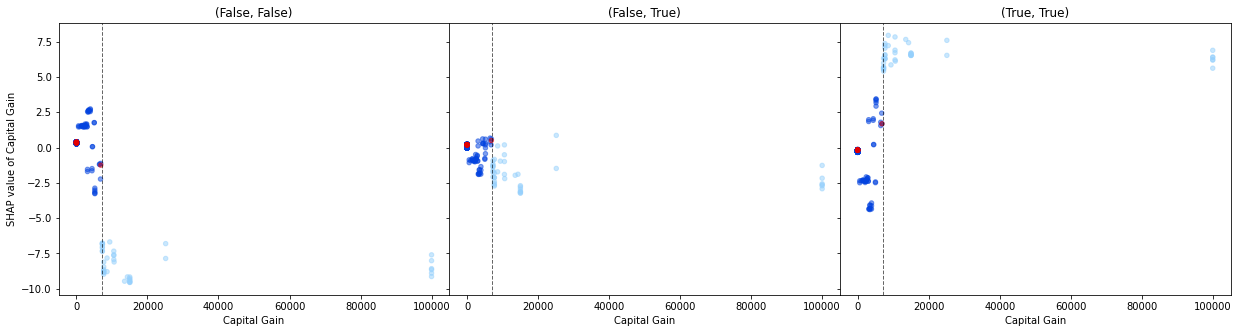

In [151]:
plot(next(feature_it))

CF is very outlying. skipping it for now.

2.0 <= Marital Status <= 5.0
[Upper CF: Marital Status == 6.0 --> {'(True, True)': 11, '(False, False)': 1}]


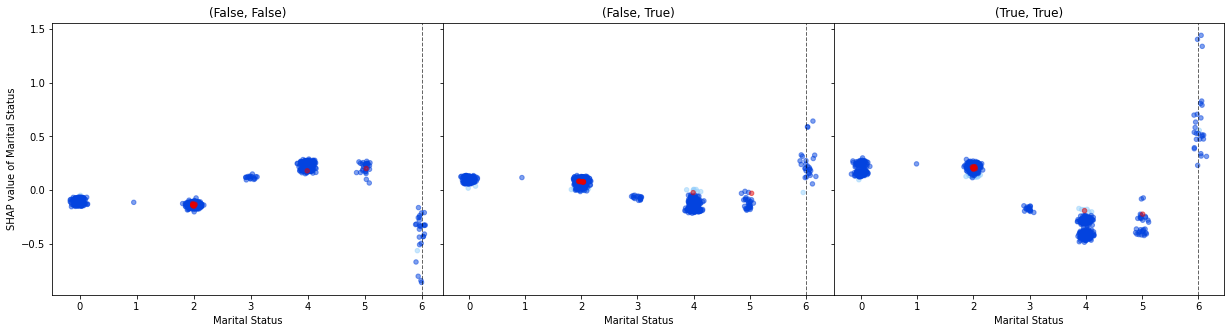

In [152]:
plot(next(feature_it))

No clear trend visible, skipping it.

Capital Loss == 0.0
[Upper CF: Capital Loss == 1448.0 --> {'(True, True)': 12}]


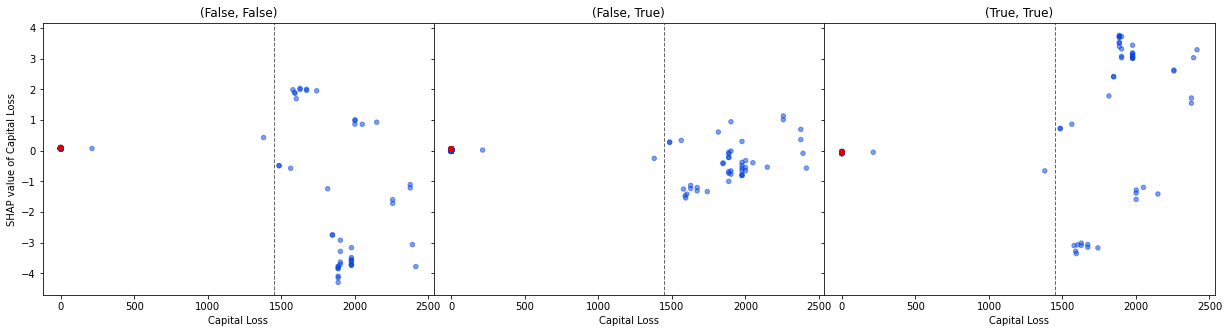

In [153]:
plot(next(feature_it))

Very outlying CF, skipping.

Race == 4.0
[Lower CF: Race == 0.0 --> {'(False, False)': 12}]


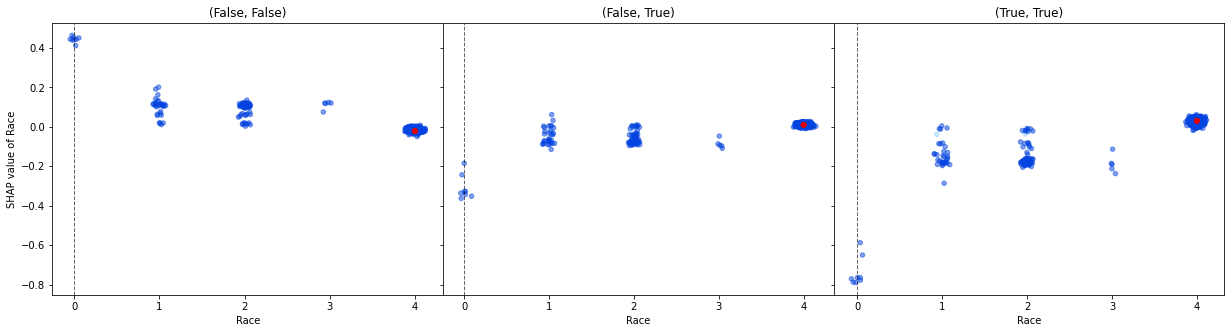

In [154]:
plot(next(feature_it))

In [23]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('Age', 'Hours per week', 'Education-Num', 'Capital Gain')
print(rule)
node.evaluate_rules(rule)

27.0 < Age <= 79.0 and 39.0 < `Hours per week` <= 41.0 and `Education-Num` > 8.0 and `Capital Gain` <= 7073.0
              precision    recall  f1-score   support

       False       1.00      0.71      0.83       924
        True       0.04      1.00      0.08        12

    accuracy                           0.72       936
   macro avg       0.52      0.86      0.46       936
weighted avg       0.99      0.72      0.82       936



,Precision,Recall,F1 Score,Support
False,1.000000,0.712121,0.831858,924
True,0.043165,1.000000,0.082759,12


In [24]:
explanations_global = [(rule, constraint, instance_indices)]

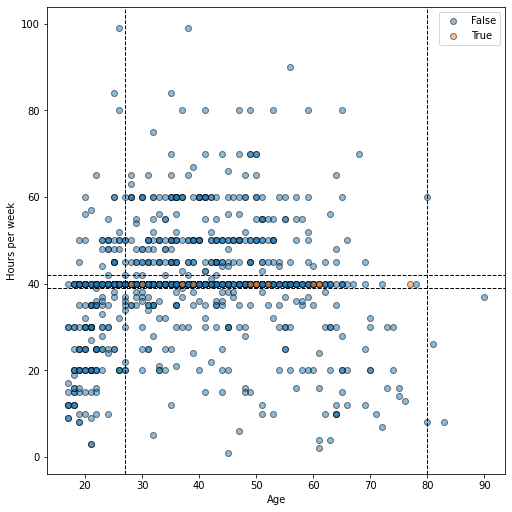

In [27]:
plot_2d(node, 'Age', 'Hours per week')

### Node 1 (RLRLR)

In [28]:
node = node.get_left().get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RLRLR,
 (False, False)    170
 (False, True)       2
 (True, True)        2
 dtype: int64,
 44.29419494339962)

The log odds estimates of these predictions are a bit closer to $(False, False)$ than to $(True, True)$.

In [30]:
feature_it = iter(node.features_with_counterfactuals)

Relationship: $=0$, while most other instances classified differently are 4 or 5. Even there is not a pronounced effect visible, the prediction changes if set to 1.

Relationship == 0.0
[Upper CF: Relationship == 1.0 --> {'(False, False)': 2}]


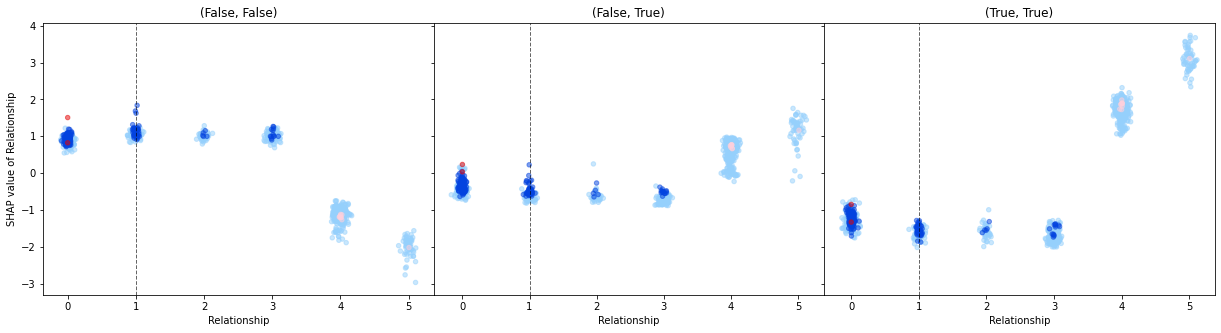

In [31]:
plot(next(feature_it))

CFs a bit narrower than in parent

39.0 <= Age <= 61.0
[Lower CF: Age == 36.0 --> {'(False, False)': 2},
 Upper CF: Age == 66.0 --> {'(False, False)': 2}]


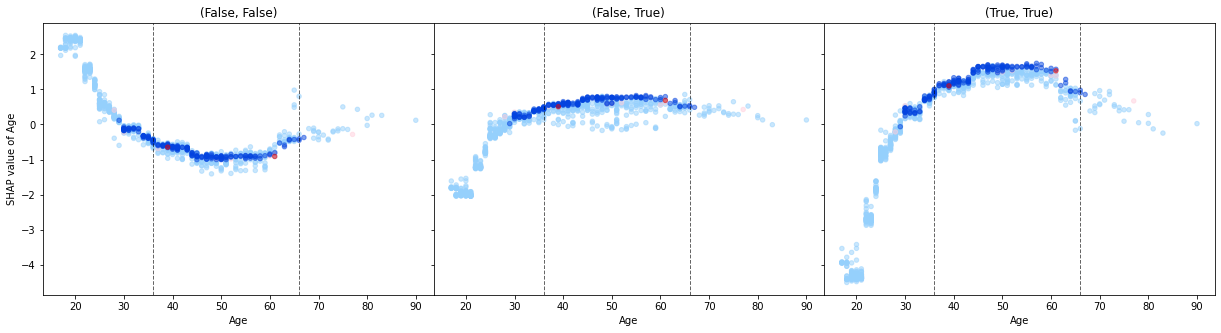

In [32]:
plot(next(feature_it))

Education-Num: is very high, prediction flips if set to 13 or lower.

14.0 <= Education-Num <= 15.0
[Lower CF: Education-Num == 13.0 --> {'(False, False)': 2}]


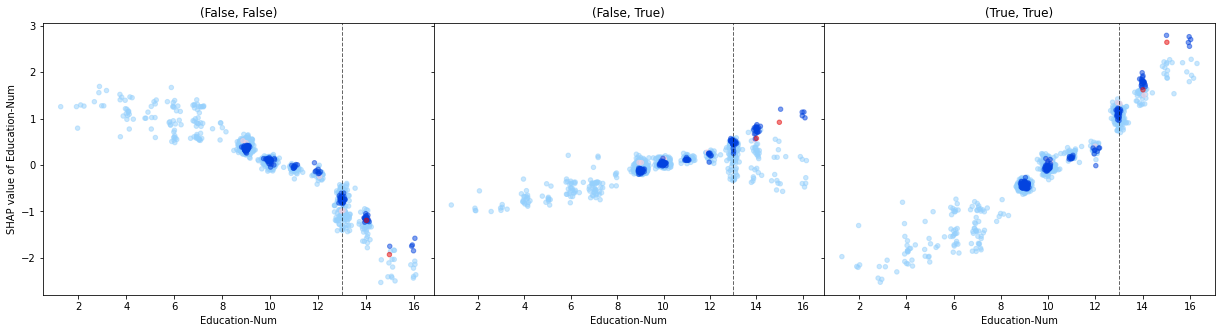

In [33]:
plot(next(feature_it))

equal to parent

Hours per week == 40.0
[Lower CF: Hours per week == 39.0 --> {'(False, False)': 2},
 Upper CF: Hours per week == 42.0 --> {'(True, True)': 2}]


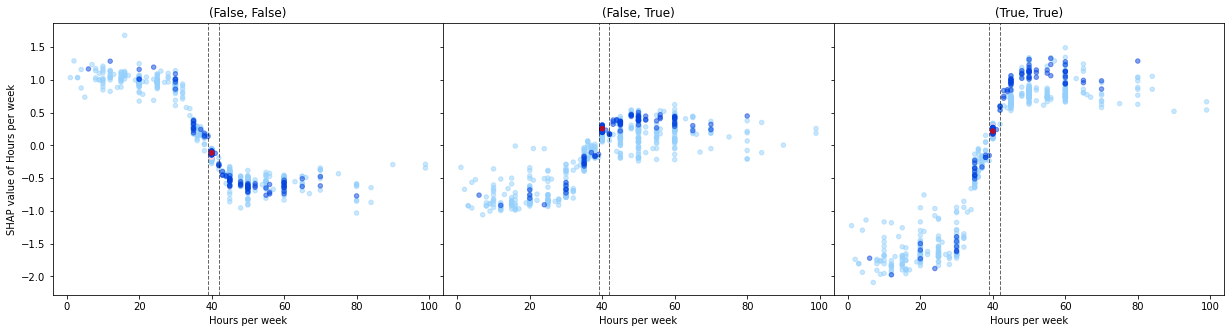

In [34]:
plot(next(feature_it))

Occupation 10-14 are very similar in terms of their outcomes, and in a local high for the difference class. Above and below the prediction flips to $(False, False)$

Occupation == 10.0
[Lower CF: Occupation == 9.0 --> {'(False, False)': 2},
 Upper CF: Occupation == 14.0 --> {'(False, False)': 2}]


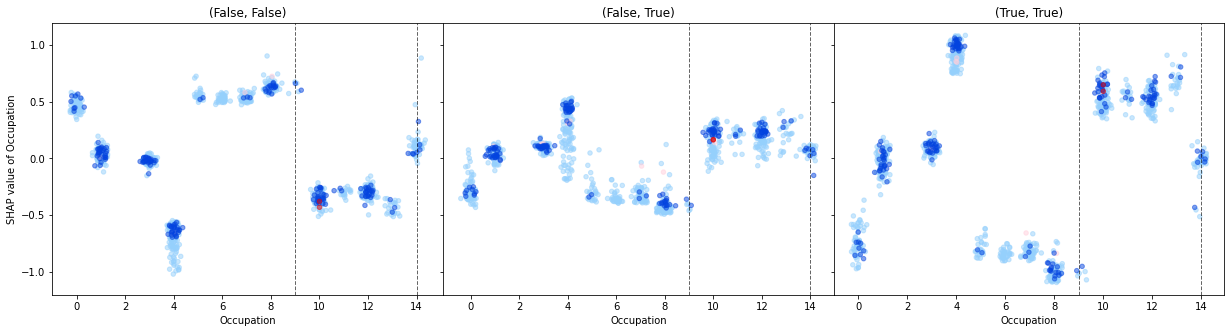

In [35]:
plot(next(feature_it))

Sex is 1 (Male) and predictions flip if set to 0 (Female) to $(False, False)$.

Sex == 1.0
[Lower CF: Sex == 0.0 --> {'(False, False)': 2}]


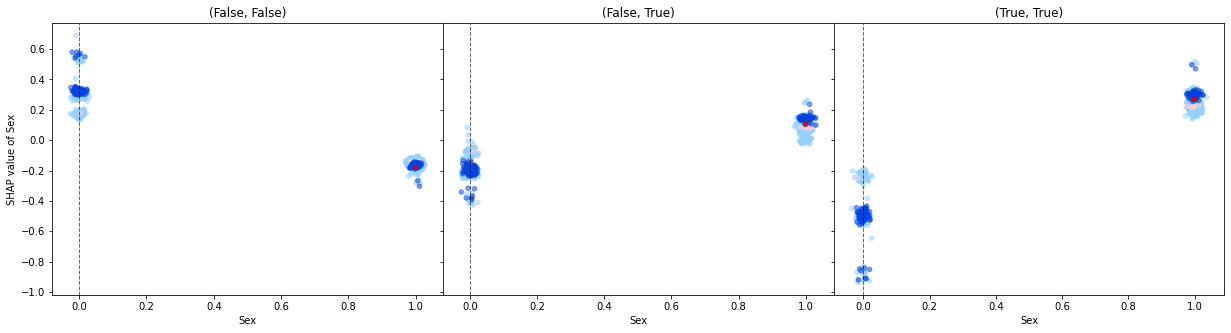

In [36]:
plot(next(feature_it))

Equal to parent

Capital Gain <= 6849.0
[Upper CF: Capital Gain == 7074.0 --> {'(True, True)': 2}]


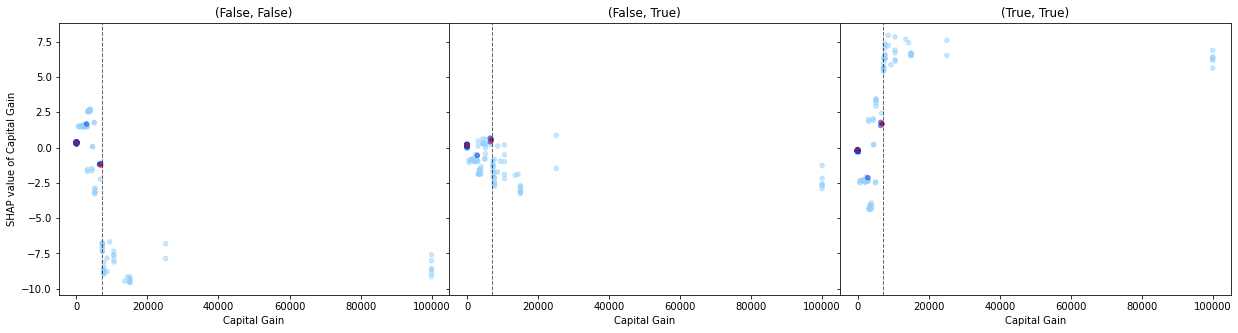

In [37]:
plot(next(feature_it))

In [38]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('Relationship', 'Age', 'Education-Num', 'Hours per week', 'Occupation', 'Sex', 'Capital Gain')
print(rule)
node.evaluate_rules(rule)

Relationship <= 0.0 and 36.0 < Age <= 65.0 and `Education-Num` > 13.0 and 39.0 < `Hours per week` <= 41.0 and 9.0 < Occupation <= 13.0 and Sex > 0.0 and `Capital Gain` <= 7073.0
              precision    recall  f1-score   support

       False       1.00      0.99      0.99       172
        True       0.50      1.00      0.67         2

    accuracy                           0.99       174
   macro avg       0.75      0.99      0.83       174
weighted avg       0.99      0.99      0.99       174



,Precision,Recall,F1 Score,Support
False,1.0,0.988372,0.994152,172
True,0.5,1.000000,0.666667,2


In [39]:
explanations_l1 = [(rule, constraint, instance_indices)]

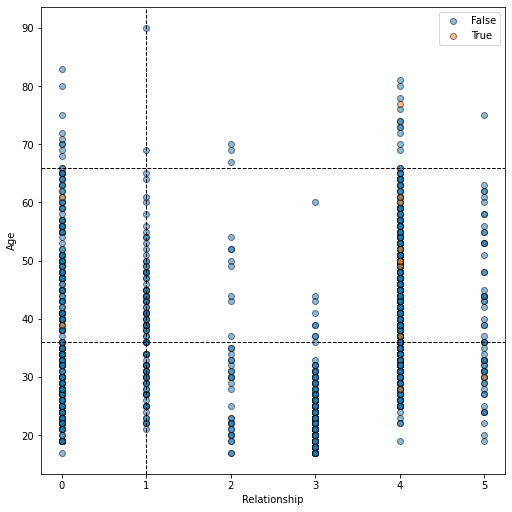

In [40]:
plot_2d(node, 'Relationship', 'Age')

### Node 2 (RRLLR)

In [41]:
node = node.root.get('RR').get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RRLLR,
 (False, False)    151
 (True, True)       96
 (False, True)      10
 dtype: int64,
 29.41299533668855)

In [43]:
feature_it = iter(node.features_with_counterfactuals)

Relationship is 4 or 5, lower values flip the prediction to $(False, False)$.

4.0 <= Relationship
[Lower CF: Relationship == 3.0 --> {'(False, False)': 10}]


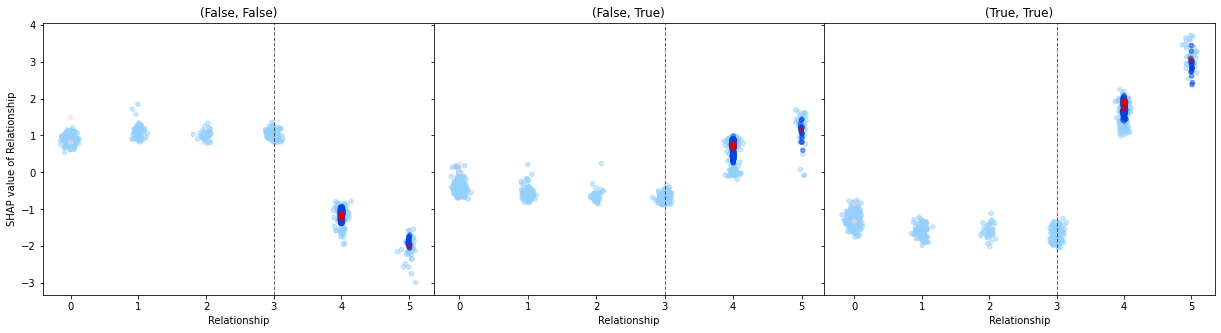

In [44]:
plot(next(feature_it))

Same as parent

28.0 <= Age <= 77.0
[Lower CF: Age == 27.0 --> {'(False, False)': 10},
 Upper CF: Age == 80.0 --> {'(False, False)': 9, '(True, True)': 1}]


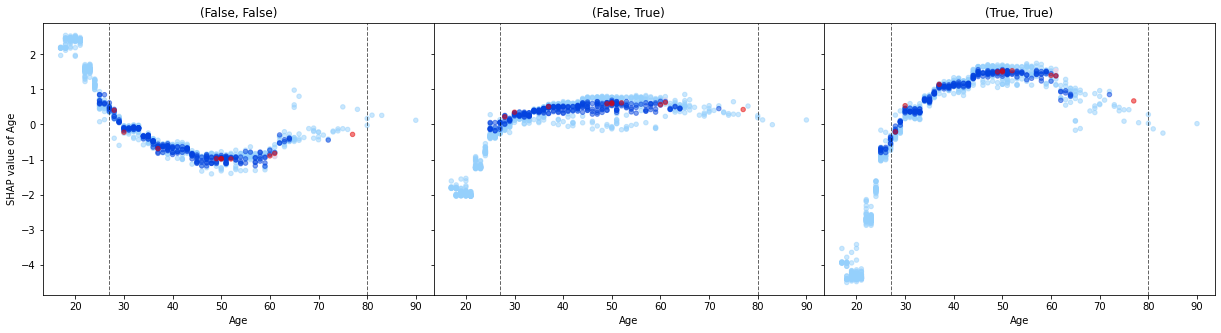

In [45]:
plot(next(feature_it))

Now has upper CF as well

9.0 <= Education-Num <= 14.0
[Lower CF: Education-Num == 8.0 --> {'(False, False)': 10},
 Upper CF: Education-Num == 15.0 --> {'(True, True)': 10}]


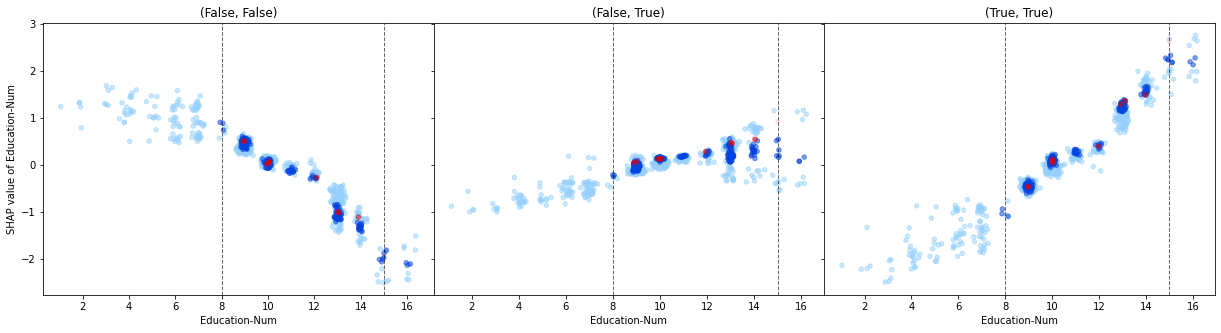

In [46]:
plot(next(feature_it))

Same as parent

Hours per week == 40.0
[Lower CF: Hours per week == 39.0 --> {'(False, False)': 10},
 Upper CF: Hours per week == 42.0 --> {'(True, True)': 10}]


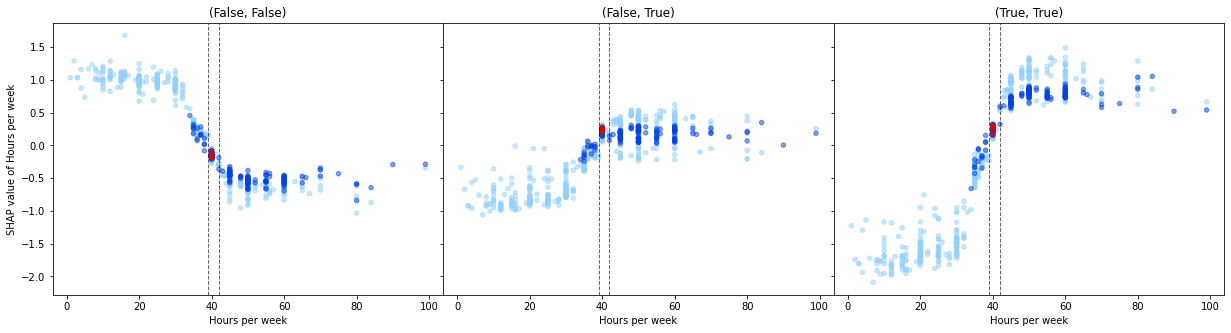

In [47]:
plot(next(feature_it))

CF now much lower

Capital Gain == 0.0
[Upper CF: Capital Gain == 57.0 --> {'(False, False)': 10}]


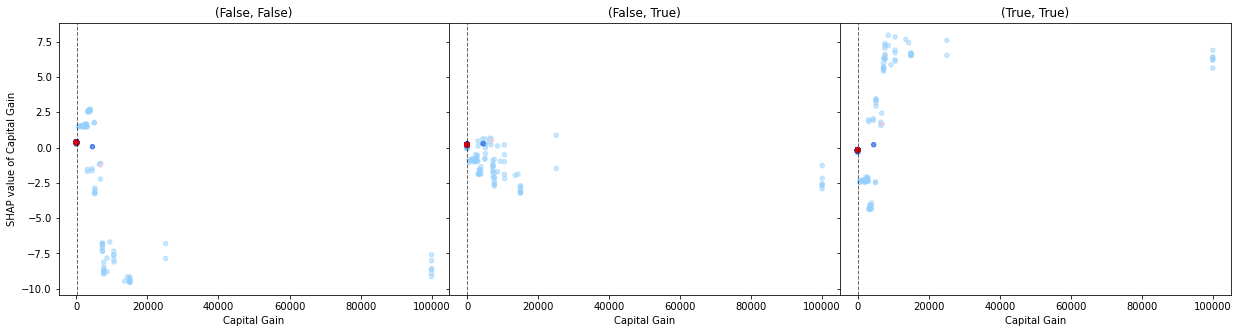

In [48]:
plot(next(feature_it))

Marital Status is 2 (Married-civ-spouse), but a similar outcome is expected for values 0, 1 and 3 but changes at 4 (Never-married) to $(False, False)$

Marital Status == 2.0
[Upper CF: Marital Status == 4.0 --> {'(False, False)': 10}]


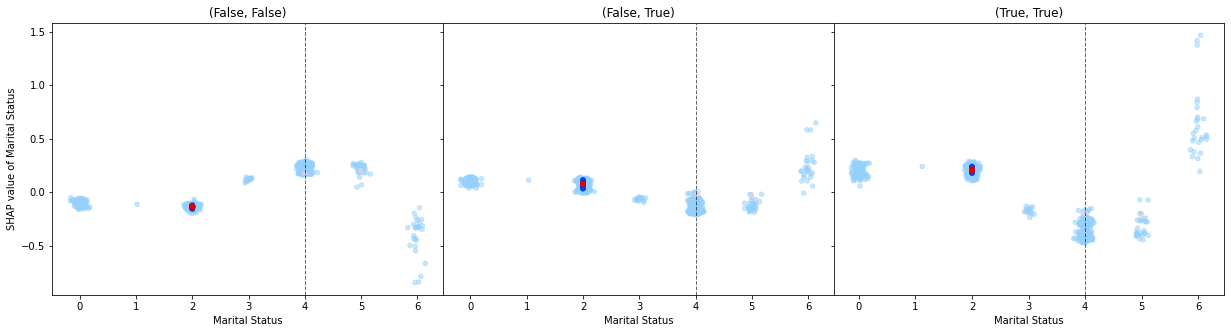

In [49]:
plot(next(feature_it))

No clear trend

Capital Loss == 0.0
[Upper CF: Capital Loss == 1448.0 --> {'(True, True)': 10}]


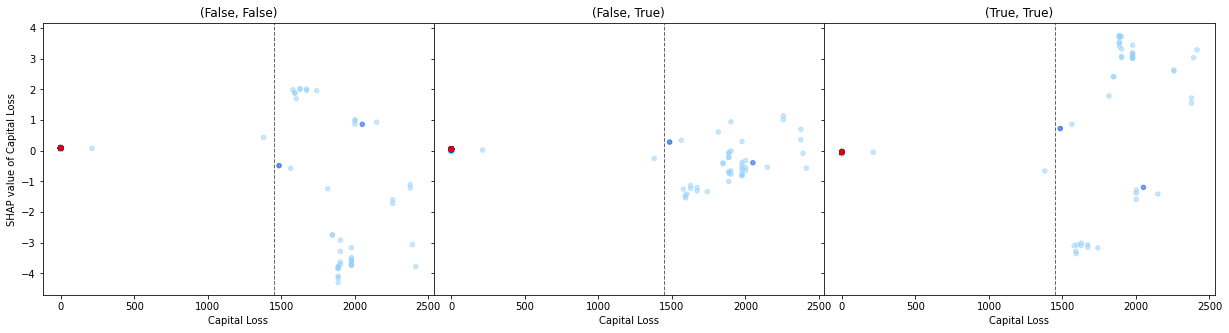

In [50]:
plot(next(feature_it))

Very outlying CF.

Race == 4.0
[Lower CF: Race == 0.0 --> {'(False, False)': 10}]


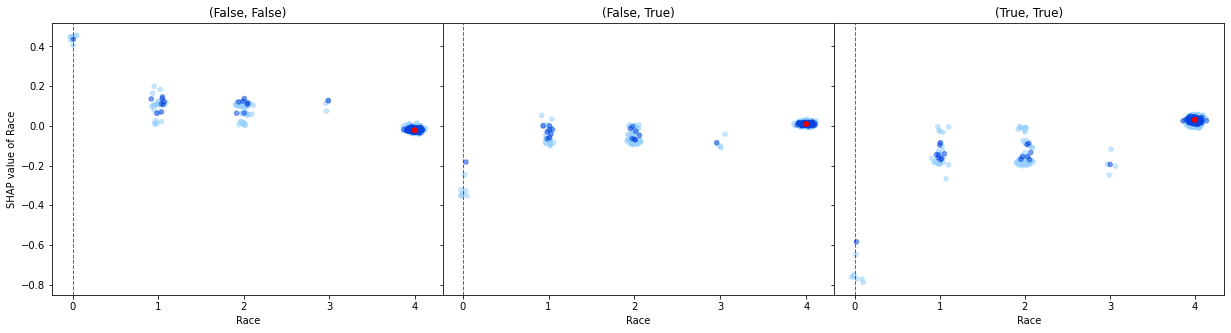

In [51]:
plot(next(feature_it))

In [52]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('Relationship', 'Age', 'Hours per week', 'Education-Num', 'Capital Gain', 'Marital Status')
print(rule)
node.evaluate_rules(rule)

Relationship > 3.0 and 27.0 < Age <= 79.0 and 8.0 < `Education-Num` <= 14.0 and 39.0 < `Hours per week` <= 41.0 and `Capital Gain` <= 56.0 and `Marital Status` <= 3.0
              precision    recall  f1-score   support

       False       1.00      0.59      0.74       247
        True       0.09      1.00      0.16        10

    accuracy                           0.60       257
   macro avg       0.54      0.79      0.45       257
weighted avg       0.96      0.60      0.72       257



,Precision,Recall,F1 Score,Support
False,1.000000,0.587045,0.739796,247
True,0.089286,1.000000,0.163934,10


In [53]:
explanations_l1.append((rule, constraint, instance_indices))

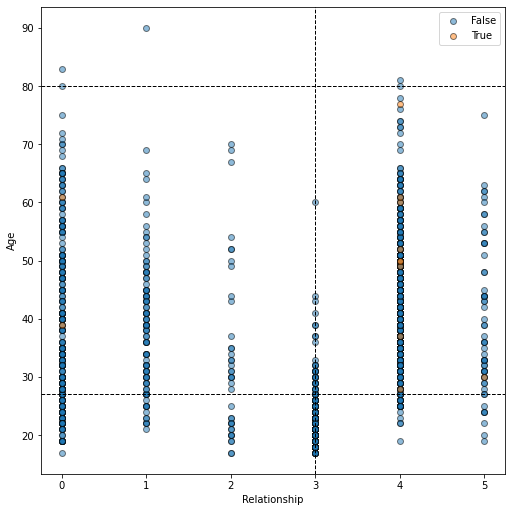

In [54]:
plot_2d(node, 'Relationship', 'Age')

### Node 2.1 (RRLLRL)

In [55]:
node = node.get_left().get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RRLLRL,
 (True, True)      65
 (False, False)     7
 (False, True)      3
 dtype: int64,
 13.966630453676805)

In [57]:
feature_it = iter(node.features_with_counterfactuals)

Same as parent

4.0 <= Relationship
[Lower CF: Relationship == 3.0 --> {'(False, False)': 3}]


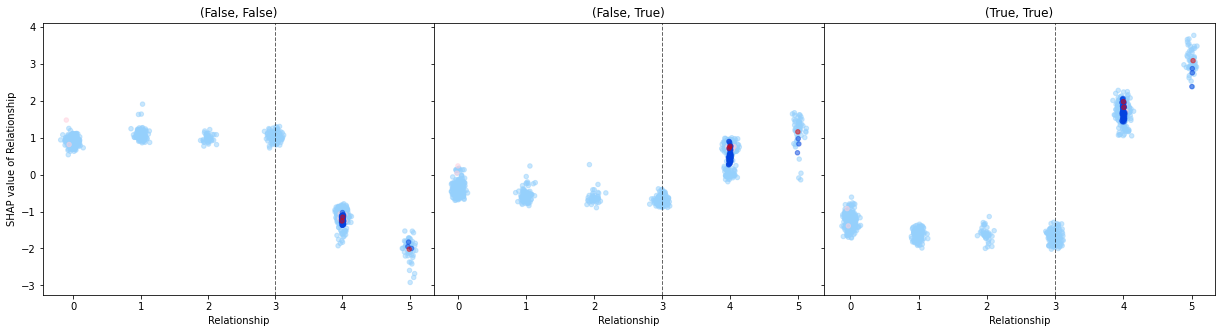

In [58]:
plot(next(feature_it))

Education-Num has now local differences for 13-14, lower CF is higher than in parent

13.0 <= Education-Num <= 14.0
[Lower CF: Education-Num == 12.0 --> {'(False, False)': 3},
 Upper CF: Education-Num == 15.0 --> {'(True, True)': 3}]


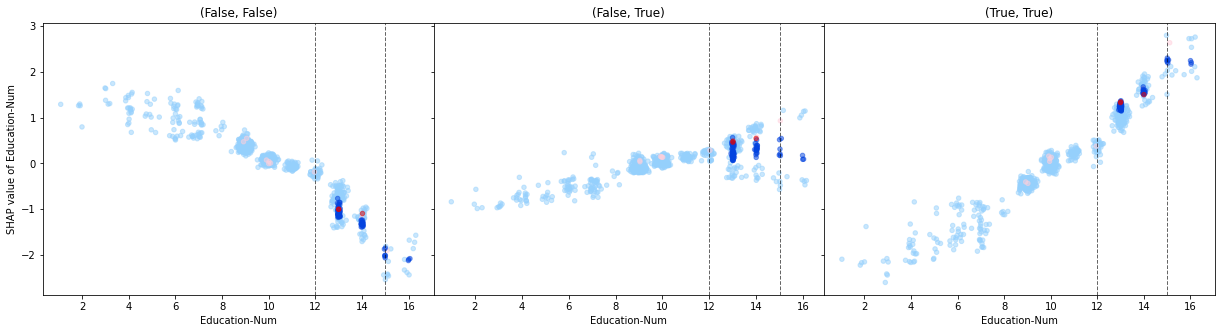

In [59]:
plot(next(feature_it))

Differences are in lower half of the parent's range, CF closer.

28.0 <= Age <= 37.0
[Lower CF: Age == 27.0 --> {'(False, False)': 3},
 Upper CF: Age == 44.0 --> {'(True, True)': 3}]


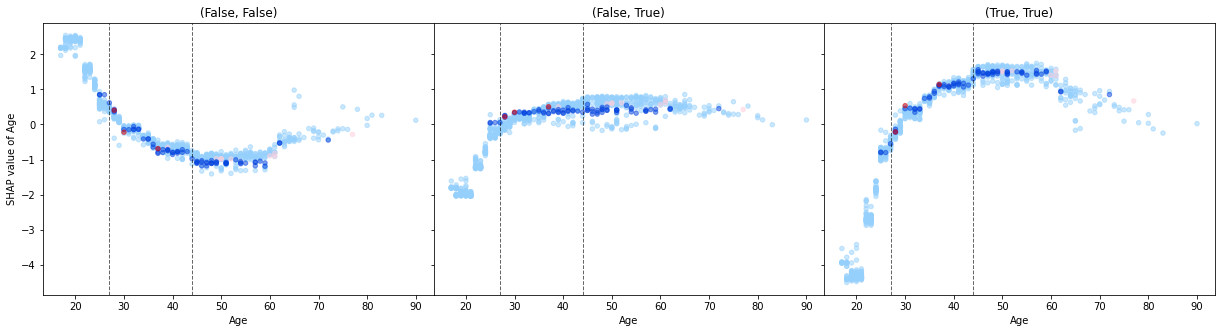

In [60]:
plot(next(feature_it))

CF not clear, not including it

7.0 <= Occupation <= 10.0
[Lower CF: Occupation == 3.0 --> {'(True, True)': 2, '(False, False)': 1}]


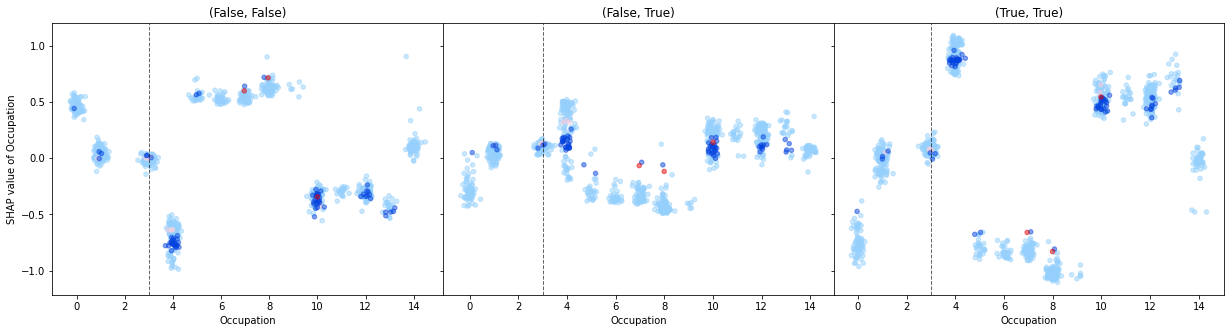

In [61]:
plot(next(feature_it))

Same as parent

Hours per week == 40.0
[Lower CF: Hours per week == 39.0 --> {'(False, False)': 3},
 Upper CF: Hours per week == 42.0 --> {'(True, True)': 3}]


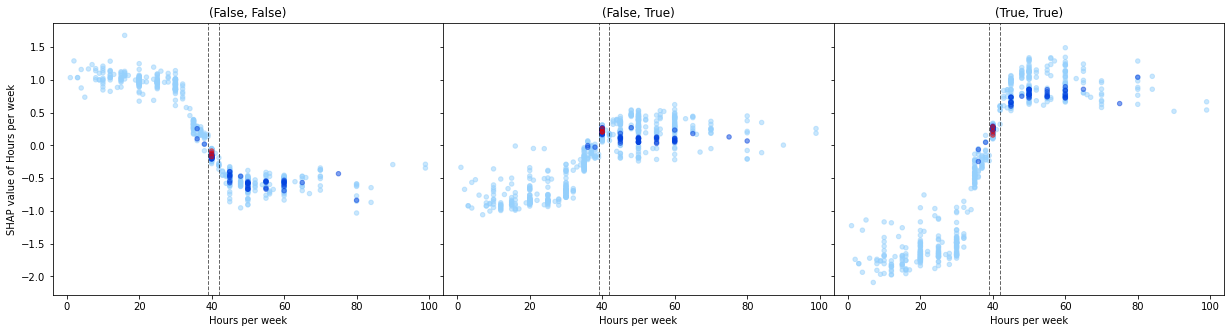

In [62]:
plot(next(feature_it))

Same as parent

Capital Gain == 0.0
[Upper CF: Capital Gain == 57.0 --> {'(False, False)': 3}]


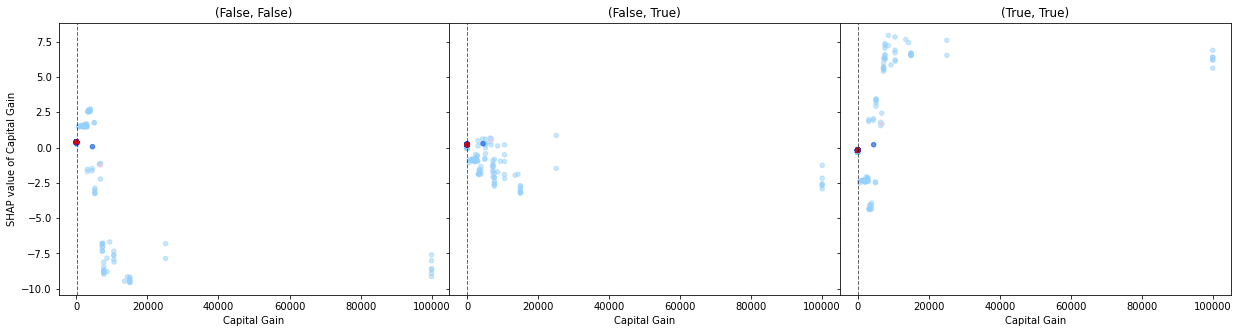

In [63]:
plot(next(feature_it))

Same as parent

Marital Status == 2.0
[Upper CF: Marital Status == 4.0 --> {'(False, False)': 3}]


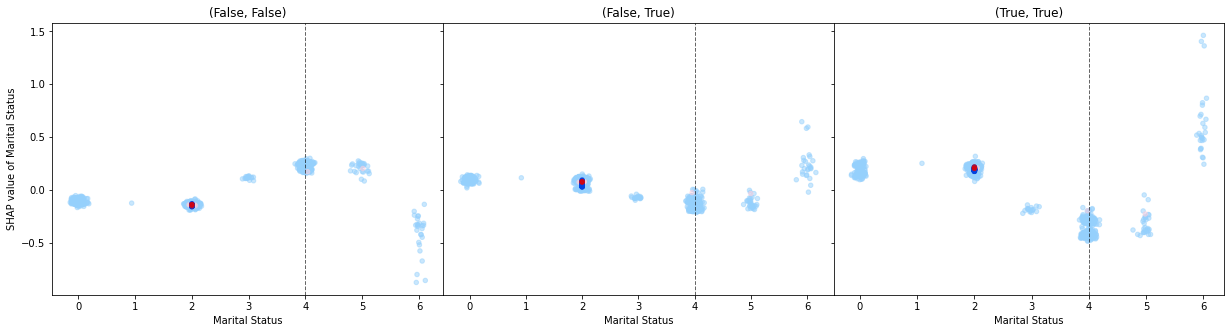

In [64]:
plot(next(feature_it))

Same as parent

Capital Loss == 0.0
[Upper CF: Capital Loss == 732.0 --> {'(False, False)': 3}]


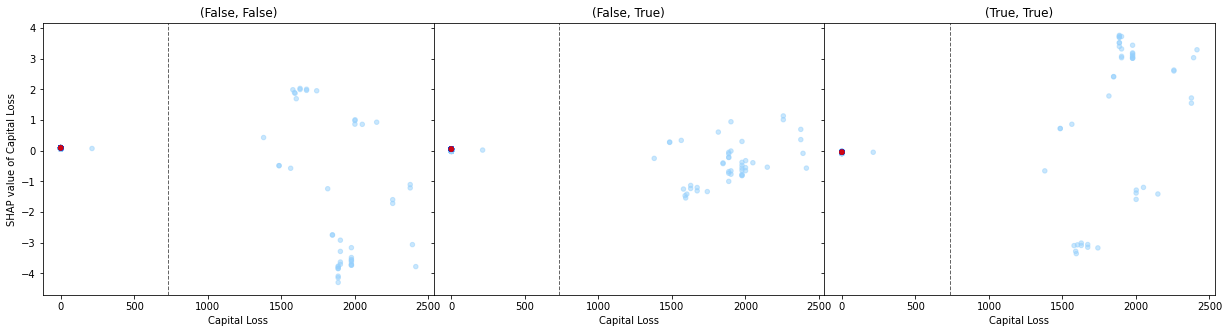

In [65]:
plot(next(feature_it))

Same as parent

Race == 4.0
[Lower CF: Race == 0.0 --> {'(False, False)': 3}]


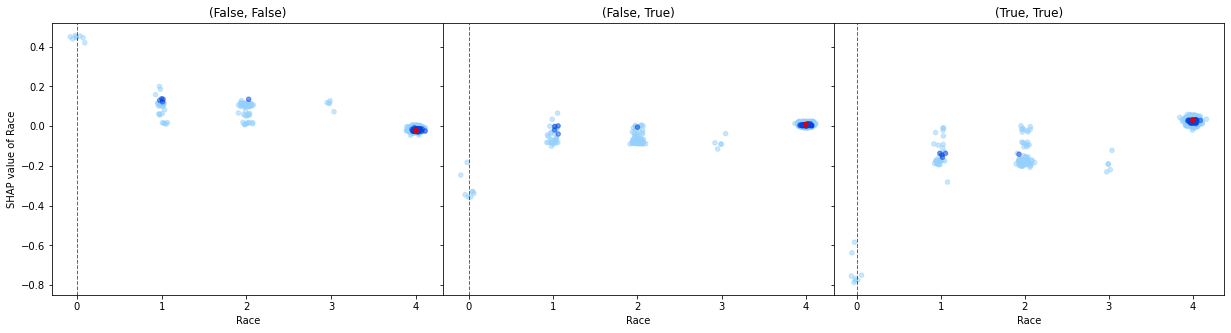

In [66]:
plot(next(feature_it))

In [67]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('Relationship', 'Education-Num', 'Age', 'Hours per week', 'Capital Gain', 'Marital Status')
print(rule)
node.evaluate_rules(rule)

Relationship > 3.0 and 12.0 < `Education-Num` <= 14.0 and 27.0 < Age <= 43.0 and 39.0 < `Hours per week` <= 41.0 and `Capital Gain` <= 56.0 and `Marital Status` <= 3.0
              precision    recall  f1-score   support

       False       1.00      0.88      0.93        72
        True       0.25      1.00      0.40         3

    accuracy                           0.88        75
   macro avg       0.62      0.94      0.67        75
weighted avg       0.97      0.88      0.91        75



,Precision,Recall,F1 Score,Support
False,1.00,0.875,0.933333,72
True,0.25,1.000,0.400000,3


In [68]:
explanations_l2 = [explanations_l1[0]]
explanations_l2.append((rule, constraint, instance_indices))

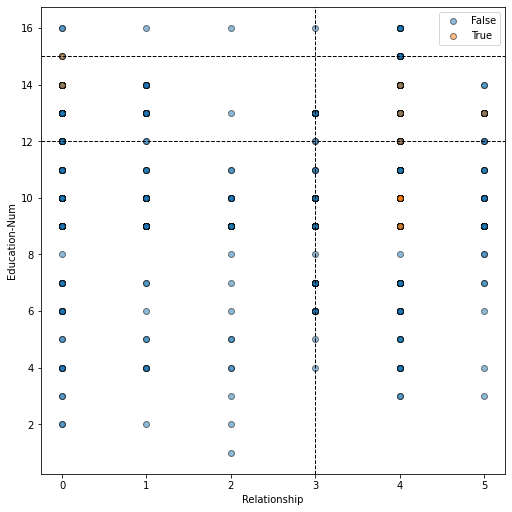

In [69]:
plot_2d(node, 'Relationship', 'Education-Num')

### Node 2.2 (RRLLRRLR)

In [70]:
node = node.root.get('RRLLRR').get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RRLLRRLR,
 (False, False)    89
 (True, True)      30
 (False, True)      7
 dtype: int64,
 6.409628398769407)

The instances in this cluster are even more similar than those of the previously analyzed cluster.

In [72]:
feature_it = iter(node.features_with_counterfactuals)

Same as parent

Relationship == 4.0
[Lower CF: Relationship == 3.0 --> {'(False, False)': 7}]


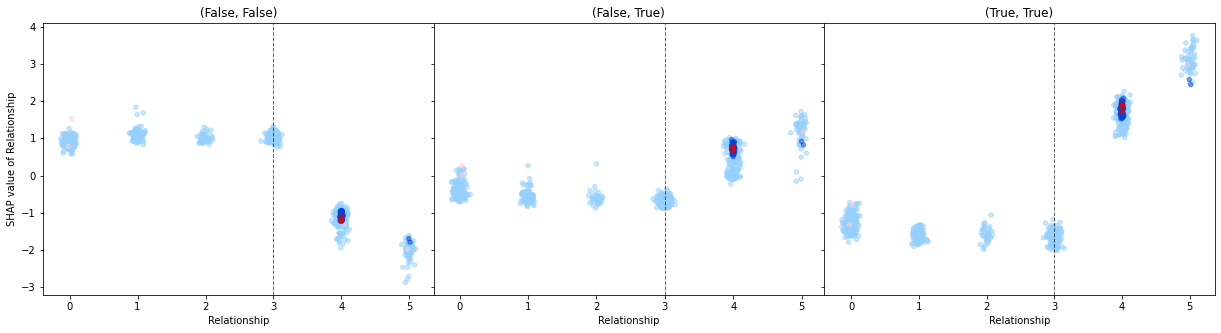

In [73]:
plot(next(feature_it))

In this cluster, there is less feature interaction (vertical spread of SHAP values) for this dependence plot visible. Lower CF now higher

49.0 <= Age <= 77.0
[Lower CF: Age == 33.0 --> {'(False, False)': 7},
 Upper CF: Age == 80.0 --> {'(False, False)': 7}]


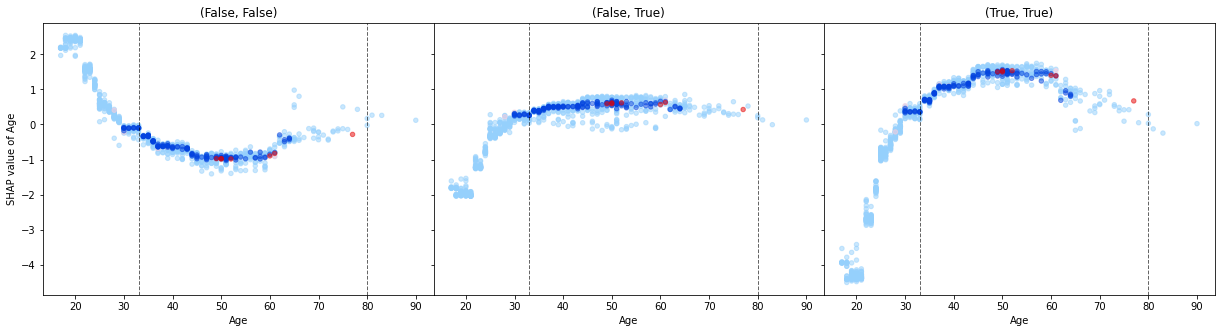

In [74]:
plot(next(feature_it))

Same as parent

Hours per week == 40.0
[Lower CF: Hours per week == 39.0 --> {'(False, False)': 7},
 Upper CF: Hours per week == 42.0 --> {'(True, True)': 7}]


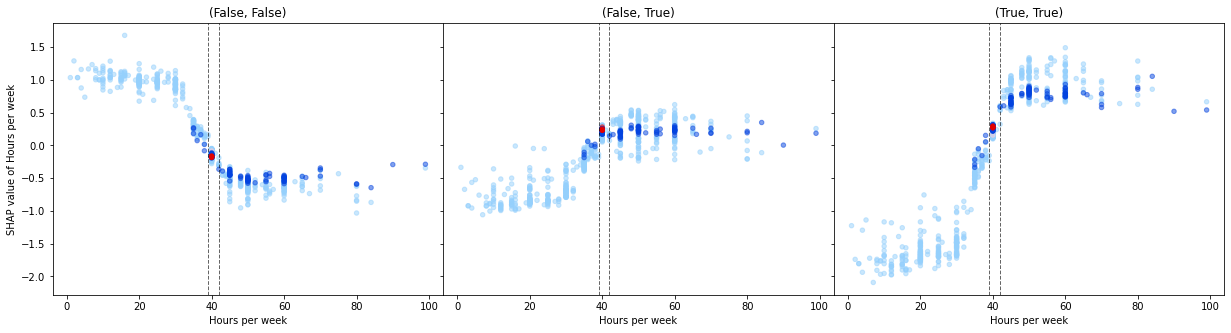

In [75]:
plot(next(feature_it))

Same as parent

Capital Gain == 0.0
[Upper CF: Capital Gain == 57.0 --> {'(False, False)': 7}]


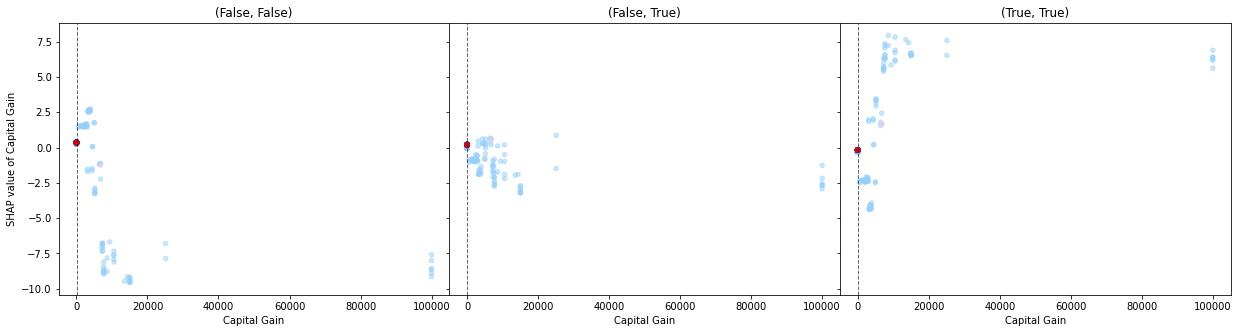

In [76]:
plot(next(feature_it))

No clear effect visible, excluding it.

1.0 <= Occupation <= 4.0
[Upper CF: Occupation == 5.0 --> {'(False, False)': 7}]


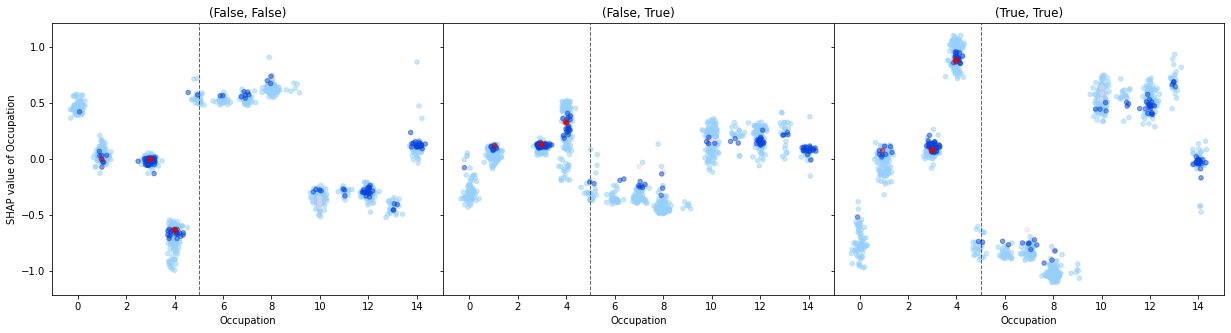

In [77]:
plot(next(feature_it))

values are lower than it sibling node, counterfactuals are close.

9.0 <= Education-Num <= 12.0
[Lower CF: Education-Num == 8.0 --> {'(False, False)': 7},
 Upper CF: Education-Num == 13.0 --> {'(True, True)': 7}]


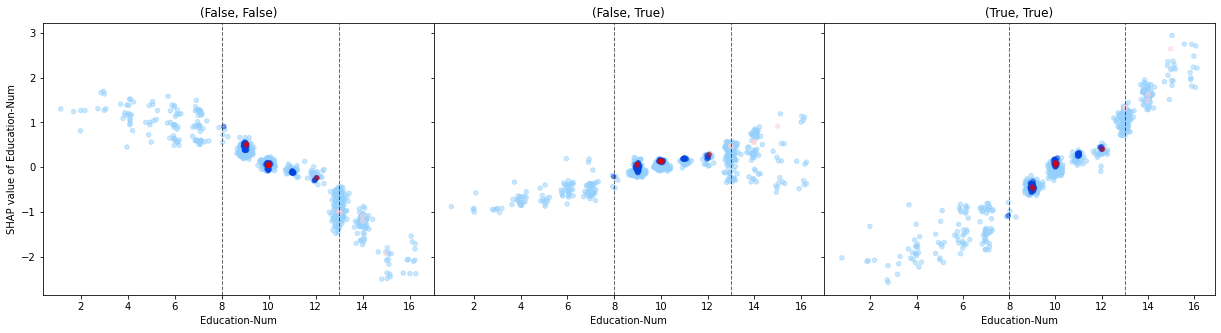

In [78]:
plot(next(feature_it))

similar to parent.

Marital Status == 2.0
[Upper CF: Marital Status == 4.0 --> {'(False, False)': 7}]


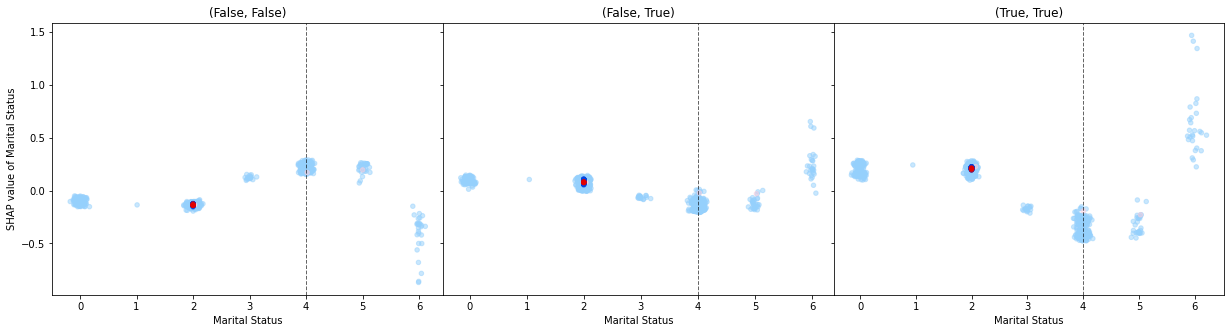

In [79]:
plot(next(feature_it))

The upper two values clearly tend to increase the outcome of $(False, False)$, with a CF.

Capital Loss == 0.0
[Upper CF: Capital Loss == 1448.0 --> {'(True, True)': 7}]


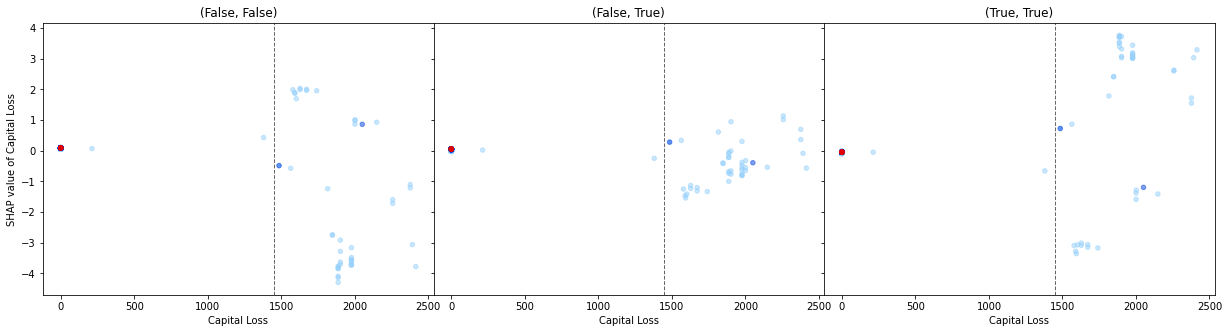

In [80]:
plot(next(feature_it))

same as parent

4.0 <= Workclass <= 5.0
[Upper CF: Workclass == 6.0 --> {'(False, False)': 7}]


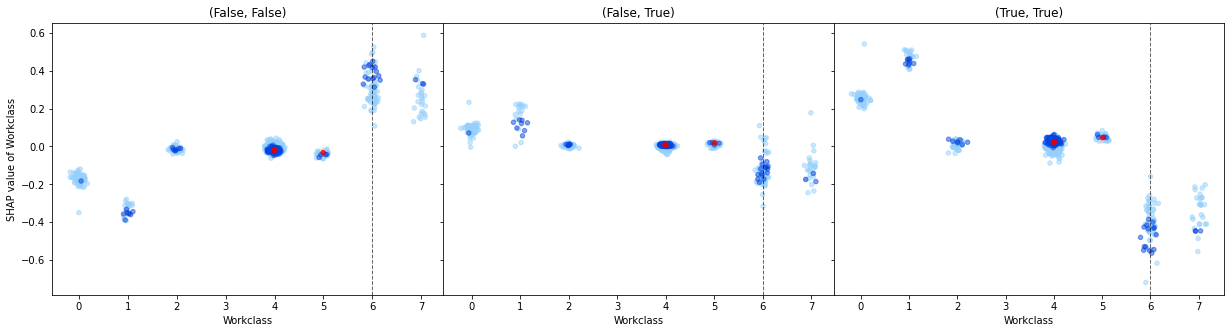

In [81]:
plot(next(feature_it))

same as parent

Race == 4.0
[Lower CF: Race == 0.0 --> {'(False, False)': 7}]


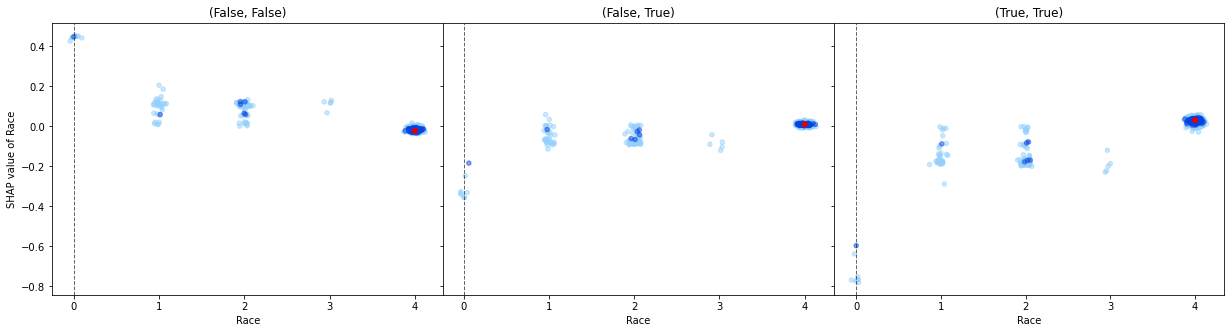

In [82]:
plot(next(feature_it))

In [83]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('Relationship', 'Age', 'Hours per week', 'Education-Num', 'Capital Gain', 'Marital Status', 'Workclass')
print(rule)
node.evaluate_rules(rule)

Relationship > 3.0 and 33.0 < Age <= 79.0 and 39.0 < `Hours per week` <= 41.0 and `Capital Gain` <= 56.0 and 8.0 < `Education-Num` <= 12.0 and `Marital Status` <= 3.0 and Workclass <= 5.0
              precision    recall  f1-score   support

       False       1.00      0.67      0.80       135
        True       0.13      1.00      0.24         7

    accuracy                           0.68       142
   macro avg       0.57      0.83      0.52       142
weighted avg       0.96      0.68      0.77       142



,Precision,Recall,F1 Score,Support
False,1.000000,0.666667,0.800000,135
True,0.134615,1.000000,0.237288,7


In [84]:
explanations_l2.append((rule, constraint, instance_indices))

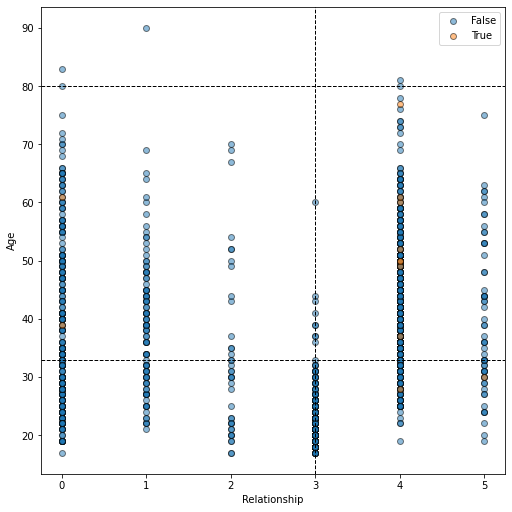

In [85]:
plot_2d(node, 'Relationship', 'Age')

### Evaluation

#### Global

In [84]:
level = 0
rules, constraints, instance_indices_per_rule = zip(*explanations_global)

In [85]:
print_rules(rules)
global_fidelities[(level, node.focus_class)] = node.root.evaluate_rules(*rules)

1. 27.0 < Age <= 79.0 and 39.0 < `Hours per week` <= 41.0 and `Education-Num` > 8.0 and `Capital Gain` <= 7073.0
              precision    recall  f1-score   support

       False       1.00      0.72      0.84       965
        True       0.04      1.00      0.08        12

    accuracy                           0.73       977
   macro avg       0.52      0.86      0.46       977
weighted avg       0.99      0.73      0.83       977



In [86]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)
local_fidelities[(level, node.focus_class)] = statistics
statistics

invalid value encountered in true_divide


,RMSE,BMR,BAR
Age,21.245588,0.000000,0.0
Workclass,NaN,1.000000,NaN
Education-Num,3.201562,0.478261,0.0
Marital Status,NaN,1.000000,NaN
Occupation,NaN,1.000000,NaN
Relationship,NaN,1.000000,NaN
Race,NaN,1.000000,NaN
Sex,NaN,1.000000,NaN
Capital Gain,6718.266015,0.076923,0.0
Capital Loss,NaN,1.000000,NaN


In [87]:
res = get_complexity(constraints)
complexities[(level, node.focus_class)] = res
res

Rules          1
Constraints    6
dtype: int64

In [88]:
with open('explanation-shap-orig-01-l0.pickle', 'wb') as f:
    pickle.dump((rules, constraints, instance_indices_per_rule), f)

#### Level 1

In [89]:
level = 1
rules, constraints, instance_indices_per_rule = zip(*explanations_l1)

In [90]:
print_rules(rules)
global_fidelities[(level, node.focus_class)] = node.root.evaluate_rules(*rules)

1. Relationship <= 0.0 and 36.0 < Age <= 65.0 and `Education-Num` > 13.0 and 39.0 < `Hours per week` <= 41.0 and 9.0 < Occupation <= 13.0 and Sex > 0.0 and `Capital Gain` <= 7073.0
2. Relationship > 3.0 and 27.0 < Age <= 79.0 and 8.0 < `Education-Num` <= 14.0 and 39.0 < `Hours per week` <= 41.0 and `Capital Gain` <= 56.0 and `Marital Status` <= 3.0
              precision    recall  f1-score   support

       False       1.00      0.88      0.94       965
        True       0.09      1.00      0.17        12

    accuracy                           0.88       977
   macro avg       0.55      0.94      0.55       977
weighted avg       0.99      0.88      0.93       977



In [91]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)
local_fidelities[(level, node.focus_class)] = statistics
statistics

invalid value encountered in true_divide


,RMSE,BMR,BAR
Age,20.527421,0.000000,0.0
Workclass,NaN,1.000000,NaN
Education-Num,2.458751,0.043478,0.0
Marital Status,0.894427,0.166667,0.0
Occupation,1.000000,0.826087,0.0
Relationship,0.288675,0.368421,0.0
Race,NaN,1.000000,NaN
Sex,0.000000,0.777778,0.0
Capital Gain,2025.633419,0.076923,0.0
Capital Loss,NaN,1.000000,NaN


In [92]:
res = get_complexity(constraints)
complexities[(level, node.focus_class)] = res
res

Rules           2
Constraints    19
dtype: int64

In [93]:
with open('explanation-shap-orig-01-l1.pickle', 'wb') as f:
    pickle.dump((rules, constraints, instance_indices_per_rule), f)

#### Level 2

In [94]:
level = 2
rules, constraints, instance_indices_per_rule = zip(*explanations_l2)

In [95]:
print_rules(rules)
global_fidelities[(level, node.focus_class)] = node.root.evaluate_rules(*rules)

1. Relationship <= 0.0 and 36.0 < Age <= 65.0 and `Education-Num` > 13.0 and 39.0 < `Hours per week` <= 41.0 and 9.0 < Occupation <= 13.0 and Sex > 0.0 and `Capital Gain` <= 7073.0
2. Relationship > 3.0 and 12.0 < `Education-Num` <= 14.0 and 27.0 < Age <= 43.0 and 39.0 < `Hours per week` <= 41.0 and `Capital Gain` <= 56.0 and `Marital Status` <= 3.0
3. Relationship > 3.0 and 33.0 < Age <= 79.0 and 39.0 < `Hours per week` <= 41.0 and `Capital Gain` <= 56.0 and 8.0 < `Education-Num` <= 12.0 and `Marital Status` <= 3.0 and Workclass <= 5.0
              precision    recall  f1-score   support

       False       1.00      0.93      0.96       965
        True       0.15      1.00      0.27        12

    accuracy                           0.93       977
   macro avg       0.58      0.97      0.62       977
weighted avg       0.99      0.93      0.96       977



In [96]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)
local_fidelities[(level, node.focus_class)] = statistics
statistics

invalid value encountered in true_divide


,RMSE,BMR,BAR
Age,11.953033,0.000000,0.0
Workclass,0.000000,0.650000,0.0
Education-Num,1.066004,0.043478,0.0
Marital Status,0.894427,0.166667,0.0
Occupation,1.000000,0.826087,0.0
Relationship,0.288675,0.368421,0.0
Race,NaN,1.000000,NaN
Sex,0.000000,0.777778,0.0
Capital Gain,2025.633419,0.076923,0.0
Capital Loss,NaN,1.000000,NaN


In [97]:
res = get_complexity(constraints)
complexities[(level, node.focus_class)] = res
res

Rules           3
Constraints    29
dtype: int64

In [99]:
with open('explanation-shap-orig-01-l2.pickle', 'wb') as f:
    pickle.dump((rules, constraints, instance_indices_per_rule), f)

### Additional plots

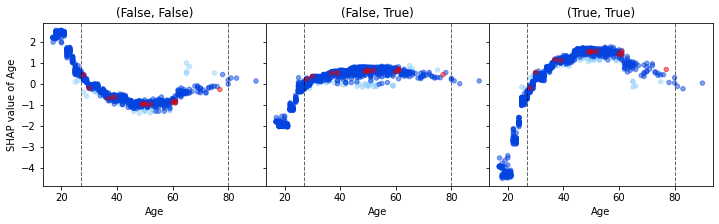

In [97]:
node = node.root.get('R')
node.root.plot_feature_dependence('Age', focus=node, alpha=0.5, figsize=(4, 3))
plt.savefig('adult-global-depplots-01-age.pdf')

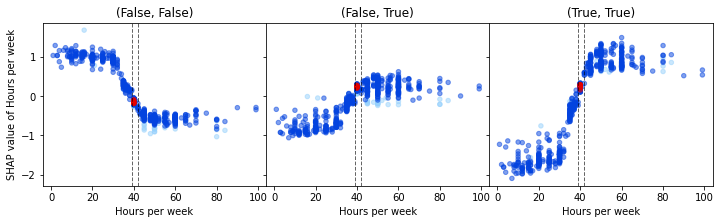

In [98]:
node = node.root.get('R')
node.root.plot_feature_dependence('Hours per week', focus=node, alpha=0.5, figsize=(4, 3))
plt.savefig('adult-global-depplots-01-hours.pdf')

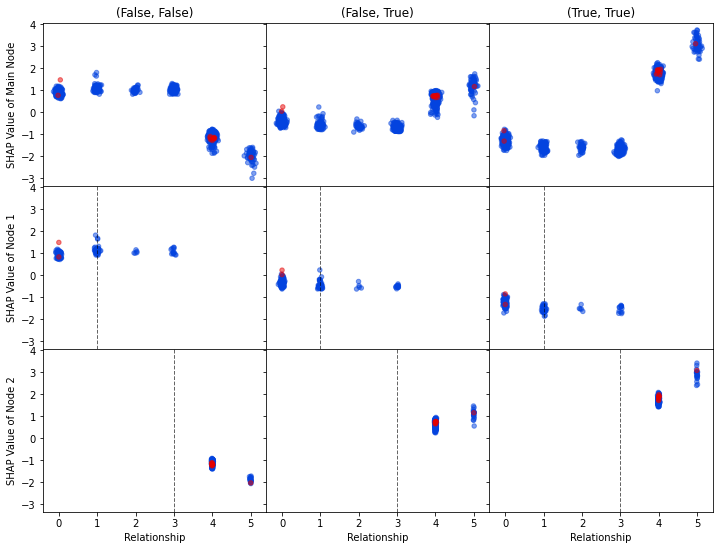

In [129]:
plot_joint_feature_dependence('Relationship', **{
    'Main Node': node.root.get('R'),
    'Node 1': node.root.get('RLRLR'),
    'Node 2': node.root.get('RRLLR')
})
plt.savefig('adult-depplots-01-relationship.pdf')

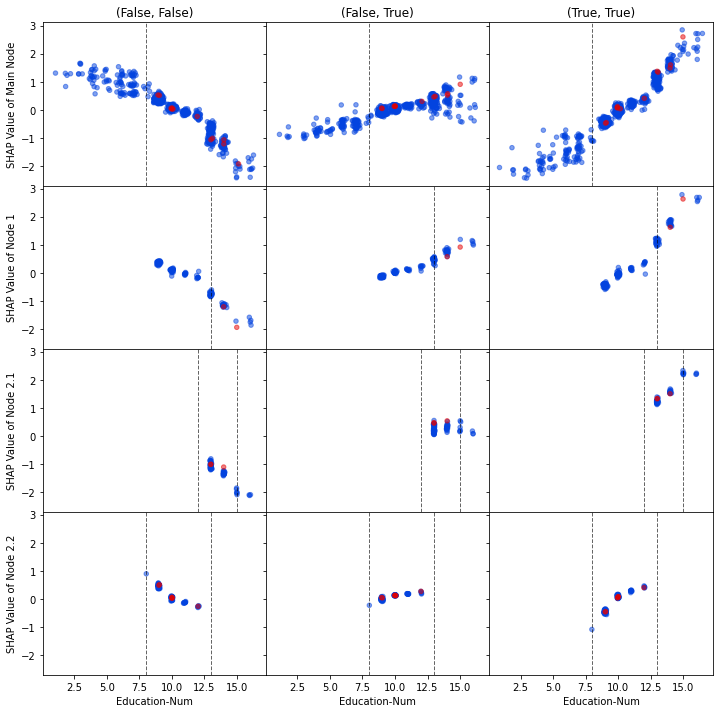

In [131]:
plot_joint_feature_dependence('Education-Num', **{
    'Main Node': node.root.get('R'),
    'Node 1': node.root.get('RLRLR'),
    'Node 2.1': node.root.get('RRLLRL'),
    'Node 2.2': node.root.get('RRLLRRLR')
})
plt.savefig('adult-depplots-01-education.pdf')

# Summary

In [100]:
def map_index(index):
    class_, level_in = index[0], index[1]
    if level_in == 0:
        level = 'global'
    elif level_in == 2:
        level = 'local'
    else:
        level = None
    return (class_, level) if len(index) == 2 else (class_, level, index[2])

## Global Fidelity

In [101]:
global_fidelity = pd.concat(global_fidelities.values(), keys=global_fidelities.keys(), names=('level', 'class'))
global_fidelity = global_fidelity[global_fidelity.index.get_level_values(2).astype(int) == 1]
global_fidelity.index = global_fidelity.index.droplevel(2)
global_fidelity = global_fidelity.reorder_levels(['class', 'level']).sort_index()
global_fidelity

Precision  Recall  F1 Score  Support
class         level                                      
(False, True) 0       0.043165     1.0  0.082759       12
              1       0.094488     1.0  0.172662       12
              2       0.153846     1.0  0.266667       12

## Local Fidelity

In [102]:
local_fidelity = pd.concat(local_fidelities.values(), keys=local_fidelities.keys(), names=('level', 'class', 'feature'))
local_fidelity = local_fidelity.reorder_levels(['class', 'level', 'feature']).sort_index()
local_fidelity

RMSE       BMR  BAR
class         level feature                                   
(False, True) 0     Age               21.245588  0.000000  0.0
                    Capital Gain    6718.266015  0.076923  0.0
                    Capital Loss            NaN  1.000000  NaN
                    Country                 NaN  1.000000  NaN
                    Education-Num      3.201562  0.478261  0.0
                    Hours per week     0.000000  0.000000  0.0
                    Marital Status          NaN  1.000000  NaN
                    Occupation              NaN  1.000000  NaN
                    Race                    NaN  1.000000  NaN
                    Relationship            NaN  1.000000  NaN
                    Sex                     NaN  1.000000  NaN
                    Workclass               NaN  1.000000  NaN
              1     Age               20.527421  0.000000  0.0
                    Capital Gain    2025.633419  0.076923  0.0
                    Capital Loss            NaN  1.000000  NaN
                    Country                 NaN  1.000000  NaN
                    Education-Num      2.458751  0.043478  0.0
                    Hours per week     0.000000  0.000000  0.0
                    Marital Status     0.894427  0.166667  0.0
                    Occupation         1.000000  0.826087  0.0
                    Race                    NaN  1.000000  NaN
                    Relationship       0.288675  0.368421  0.0
                    Sex                0.000000  0.777778  0.0
                    Workclass               NaN  1.000000  NaN
              2     Age               11.953033  0.000000  0.0
                    Capital Gain    2025.633419  0.076923  0.0
                    Capital Loss            NaN  1.000000  NaN
                    Country                 NaN  1.000000  NaN
                    Education-Num      1.066004  0.043478  0.0
                    Hours per week     0.000000  0.000000  0.0
                    Marital Status     0.894427  0.166667  0.0
                    Occupation         1.000000  0.826087  0.0
                    Race                    NaN  1.000000  NaN
                    Relationship       0.288675  0.368421  0.0
                    Sex                0.000000  0.777778  0.0
                    Workclass          0.000000  0.650000  0.0

## Complexity

In [103]:
complexity = pd.concat(complexities.values(), axis=1, keys=complexities.keys(), names=('level', 'class')).T
complexity = complexity.reorder_levels(['class', 'level']).sort_index()
complexity

Rules  Constraints
class         level                    
(False, True) 0          1            6
              1          2           19
              2          3           29

## Generation Time

Total: approx. 39min

In [104]:
global_fidelity.index = global_fidelity.index.map(map_index)
global_fidelity = global_fidelity[global_fidelity.index.get_level_values('level').notnull()]

local_fidelity.index = local_fidelity.index.map(map_index)
local_fidelity = local_fidelity[local_fidelity.index.get_level_values('level').notnull()]

complexity.index = complexity.index.map(map_index)
complexity = complexity[complexity.index.get_level_values('level').notnull()]

with open('results.proposed.pickle', 'wb') as f:
    pickle.dump((global_fidelity, local_fidelity, complexity), f)